## Student Name: Aryank Gupta

## Student ID: 24101613

# Imports

You should not import any further functionality. If you feel this is required to complete the task, please discuss with your moderator.

In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [3]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier

# Provided code
The below code is not necessarily complete or applicable to all tasks. Read and understand the code so that you can use wisely and adapt as required.

In [4]:
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

To compare the SVM with a NN:

In [5]:
def plot_decisions(X, y, model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_errors = 1- train_scores
    test_errors = 1-test_scores

    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")


    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [7]:
class MLPWrapper(BaseEstimator, ClassifierMixin):

    def __init__(self, layer1=10, layer2=10):
        self.layer1 = layer1
        self.layer2 = layer2

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2],
            max_iter = 1000,
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [8]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=40,
)

In [9]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=40,
)

# Solutions

## Task 1

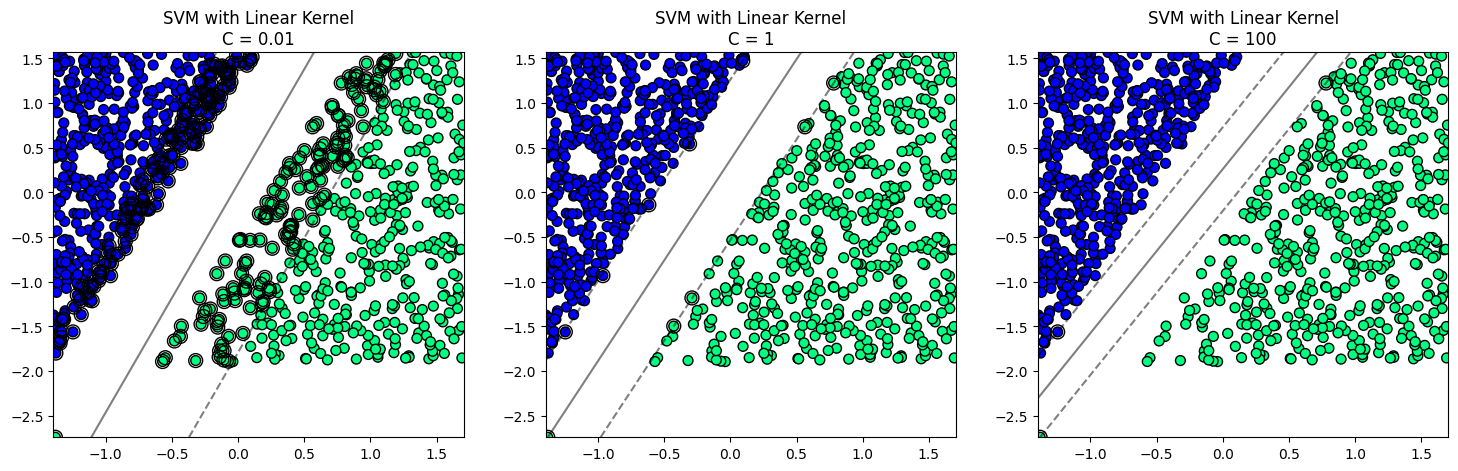

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Load the dataset using NumPy
dataset_path = 'dataset_1_train.csv'
data = np.loadtxt(dataset_path, delimiter=",", skiprows=1)  # Assuming the first row is headers

# Assuming the first two columns are features and the last column is the target
X = data[:, :-1]
y = data[:, -1]

# Function to plot SVM decision boundaries
def plot_svm_decision_boundary(svm_model, X, y, ax, title):
    # Fit model
    svm_model.fit(X, y)

    # Plot the data points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', edgecolors='k', s=50)

    # Creating grid to evaluate model
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = svm_model.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Plot support vectors
    ax.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    ax.set_title(title)

# Define different C values for comparison
C_values = [0.01, 1, 100]

# Set up the figure for plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train SVM and plot decision boundaries for each C value
for i, C in enumerate(C_values):
    svm_model = SVC(kernel='linear', C=C)
    plot_svm_decision_boundary(svm_model, X, y, axes[i], f'SVM with Linear Kernel\nC = {C}')

plt.show()


## Answers to questions

1. Effect of Varying the C-parameter on the SVM Margin: In SVM models, the C-parameter regulates the trade-off between minimizing training errors and maximizing model generalizability through the margin's width. Low C-values allow for a wider margin and more misclassifications, leading to a simpler and more generalized decision boundary—termed "soft margin" classification. This setting helps the model to overlook fine details and focus on broader trends, enhancing its performance on unseen data. Conversely, high C-values strive for fewer training errors with a narrower margin, resulting in a "hard margin" classification that fits closely to the training data, which may increase model complexity and risk of overfitting, especially if the training data is not fully representative of future data scenarios.

2. Impact of Margin Width on Generalization Abilities: The margin width in an SVM crucially impacts its ability to generalize. A wider margin, achieved by setting a lower C-value, suggests a model with reduced complexity, enhancing robustness and reducing the likelihood of overfitting. This configuration is favored for achieving consistent performance across diverse datasets by prioritizing major data trends over minute specifics. In contrast, a narrower margin from a higher C-value indicates a model that fits very closely to the training data, which might perform well on similar data but tends to overfit, capturing noise and anomalies that degrade its performance on new, unencountered datasets, limiting its generalizability.

# Task 2

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load data using pandas
dataset_2 = pd.read_csv('dataset_2_train.csv')
dataset_3 = pd.read_csv('dataset_3_train.csv')

# Separate features and target
X2 = dataset_2.iloc[:, :-1].values # Use .values to get NumPy array
y2 = dataset_2.iloc[:, -1].values
X3 = dataset_3.iloc[:, :-1].values
y3 = dataset_3.iloc[:, -1].values

# Standardize features
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)
X3 = scaler.fit_transform(X3)

# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3)
grid_search.fit(X2_train, y2_train)

print(f"Best parameters for Dataset 2: {grid_search.best_params_}")
print(f"Test set accuracy: {grid_search.score(X2_test, y2_test)}")



Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, 

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Create a neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=300, random_state=42)

# Fit model on training data
nn_model.fit(X3_train, y3_train)

# Predict on the test set
y3_pred = nn_model.predict(X3_test)

# Calculate accuracy
accuracy = accuracy_score(y3_test, y3_pred)
print(f"Test set accuracy: {accuracy}")


Test set accuracy: 0.9552238805970149


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'C': Real(0.1, 100, prior='log-uniform'),
    'gamma': Real(0.001, 1, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'poly'])
}

bayes_search = BayesSearchCV(SVC(), search_space, n_iter=30, cv=3, n_jobs=-1)
bayes_search.fit(X2_train, y2_train)

print(f"Best parameters found: {bayes_search.best_params_}")
print(f"Test accuracy: {bayes_search.score(X2_test, y2_test)}")


Best parameters found: OrderedDict([('C', 1.8209814324306928), ('gamma', 1.0), ('kernel', 'rbf')])
Test accuracy: 0.7611940298507462


## Answers to Questions

How does the number of hyper-parameters to be tuned affect the length/computational complexity of the Bayesian tuning process?


And how would this compare to a grid search?  


For dataset 2, which model was the most complex and why did you come to this conclusion?


For dataset 3, which model was the most complex and why did you come to this conclusion?

Understanding Bayesian Optimization and Grid Search: When it comes to tuning our models, think of Bayesian optimization as a smart and intuitive guide that learns as it goes. It uses past tests to make educated guesses about where to look next for the best settings. This method is especially useful because it doesn't waste time retesting bad ideas; instead, it focuses on areas that show promise. However, as we add more settings (hyperparameters) to fine-tune, even this smart method needs to think harder and longer to make good predictions, slowing down each step a bit.

On the other hand, grid search is like meticulously checking every single possibility on a list. It doesn’t remember or learn; it just checks everything. When you only have a few settings to adjust, it’s perfectly fine, but as you increase these settings, grid search becomes exhaustingly slow and inefficient because it tries every single combination imaginable, even the ones that are unlikely to work.

Thinking About Model Complexity: Complexity in models is not just about how big they are but also how they handle data. For instance, a neural network with many layers and a lot of neurons can learn very detailed and complex patterns, much like an artist who has many different brushes and colors at their disposal. This kind of network could potentially be more complex than other models if it’s designed to delve deep into the data’s intricacies.

Alternatively, an SVM (Support Vector Machine) using a sophisticated approach like the RBF (radial basis function) kernel can also be quite complex. This approach allows the SVM to draw very intricate boundaries around data points, similar to a craftsman carving out detailed patterns in wood. If we use this kind of kernel in an SVM, it might outshine simpler neural networks in terms of complexity due to its ability to mold high-dimensional spaces creatively.

Context for Dataset 2: If we had a deep and well-populated neural network competing against a basic SVM in this dataset, the neural network would likely be more complex. However, if the SVM was finely tuned with a capable kernel, it might give the neural network a run for its money in terms of complexity, depending on how intricate the resulting decision boundaries needed to be.

Thinking About Model Complexity: Complexity in models is not just about how big they are but also how they handle data. For instance, a neural network with many layers and a lot of neurons can learn very detailed and complex patterns, much like an artist who has many different brushes and colors at their disposal. This kind of network could potentially be more complex than other models if it’s designed to delve deep into the data’s intricacies.

Alternatively, an SVM (Support Vector Machine) using a sophisticated approach like the RBF (radial basis function) kernel can also be quite complex. This approach allows the SVM to draw very intricate boundaries around data points, similar to a craftsman carving out detailed patterns in wood. If we use this kind of kernel in an SVM, it might outshine simpler neural networks in terms of complexity due to its ability to mold high-dimensional spaces creatively.

Context for Dataset 2: If we had a deep and well-populated neural network competing against a basic SVM in this dataset, the neural network would likely be more complex. However, if the SVM was finely tuned with a capable kernel, it might give the neural network a run for its money in terms of complexity, depending on how intricate the resulting decision boundaries needed to be.

# Reflection

Reflecting on this activity involving SVMs, Neural Networks, and Bayesian optimization, I've deeply enhanced my understanding of machine learning complexities and model tuning. Experimenting with different SVM kernels and parameters demonstrated how crucial these choices are for model performance and generalization. Building and tuning neural networks revealed the intricate balance between learning capacity and overfitting. The application of Bayesian optimization revolutionized my approach to hyperparameter tuning, making it more strategic and efficient. This comprehensive exercise has not only equipped me with practical skills applicable to various data science challenges but also inspired ongoing learning and experimentation in advanced machine learning techniques. Overall, it has greatly expanded my technical toolkit and appreciation for the nuanced art of model optimization.